# Baseline Multi-Layer Perceptron

## Loading MNIST

In [1]:
import torch
import torchbearer

import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

In [3]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [4]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [5]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

In [6]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

Compute number of instances of each class by iteraing over training data.

In [7]:
class_counts = torch.zeros(10, dtype=torch.int32)

for (images, labels) in trainloader:
    one_hot_labels = F.one_hot(labels, num_classes=-1) # -1 means auto-infer class count
    one_hot_labels_count = one_hot_labels.sum(0)
    class_counts += one_hot_labels_count

print(class_counts)

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=torch.int32)


## Define MLP Model

In [8]:
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

## Train model

In [9]:
def eval_accuracy(predictions, labels):
    return ((torch.eq(predictions, labels).sum() / labels.shape[0])).item()

In [14]:
def baseline_mlp_train(trainloader, testloader, epochs = 10, width=784):
    # note 28x28 flattened image corresponds to vector of length 784
    model = BaselineModel(input_size=784, hidden_size=width, num_classes=10)
    
    loss_fn = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters())
    
    training_losses = []
    training_accuracies = []
    test_accuracies = []
    
    for epoch in tqdm(range(epochs)):
        ep_loss = 0.0
        ep_acc_train = 0.0
        ep_acc_test = 0.0
        for (images, labels) in trainloader:
            # zero gradients
            optimiser.zero_grad()
            # compute loss
            output = model(images)
            loss = loss_fn(output, labels)
            # backprop
            loss.backward()
            # step optimiser
            optimiser.step()
            # track epoch loss
            ep_loss += loss.item()

        # track epoch accuracy (train)
        for (train_images, train_labels) in testloader:
            output_test = model(images)
            _, preds = torch.max(output_test.data, dim=1)
            ep_acc_train += eval_accuracy(preds, labels)
        training_accuracies.append(ep_acc_train)

        # track epoch accuracy (test)
        for (test_images, test_labels) in testloader:
            output_test = model(test_images)
            _, preds_test = torch.max(output_test.data, dim=1)
            ep_acc_test += eval_accuracy(preds_test, test_labels)
        test_accuracies.append(ep_acc_test)
        training_losses.append(ep_loss)
        
    return training_losses, training_accuracies, test_accuracies

In [17]:
epochs = 1000
train_loss, train_acc, test_acc = baseline_mlp_train(trainloader, testloader, epochs)

100%|██████████| 1000/1000 [5:12:32<00:00, 18.75s/it] 


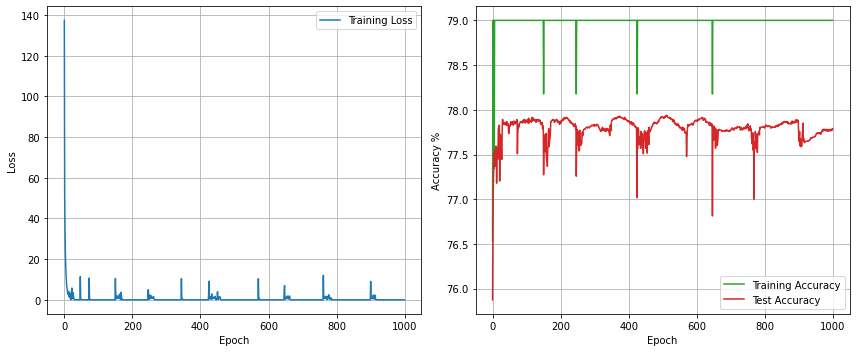

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].plot(range(epochs), train_loss, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend(loc='best', frameon=True)

ax[1].plot(range(epochs), train_acc, label='Training Accuracy', color='tab:green')
ax[1].plot(range(epochs), test_acc, label='Test Accuracy', color='tab:red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].grid(True)
ax[1].legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('images/baseline_mlp_learning_curve_ep_1000.png')

In [11]:
epochs = 50
train_loss, train_acc, test_acc = baseline_mlp_train(trainloader, testloader, epochs)

100%|██████████| 50/50 [10:54<00:00, 13.09s/it]


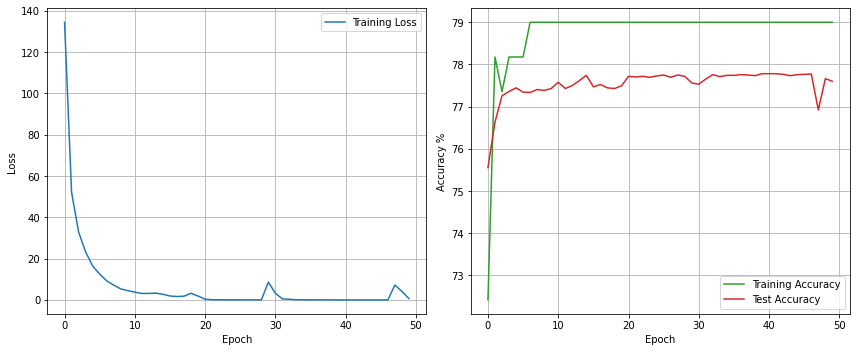

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].plot(range(epochs), train_loss, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend(loc='best', frameon=True)

ax[1].plot(range(epochs), train_acc, label='Training Accuracy', color='tab:green')
ax[1].plot(range(epochs), test_acc, label='Test Accuracy', color='tab:red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].grid(True)
ax[1].legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig(f'images/baseline_mlp_learning_curve_ep_{epochs}.png')

In [16]:
epochs = 10
hidden_units = 1000
train_loss, train_acc, test_acc = baseline_mlp_train(trainloader, testloader, 
                                                     epochs, hidden_units)

100%|██████████| 10/10 [02:58<00:00, 17.89s/it]


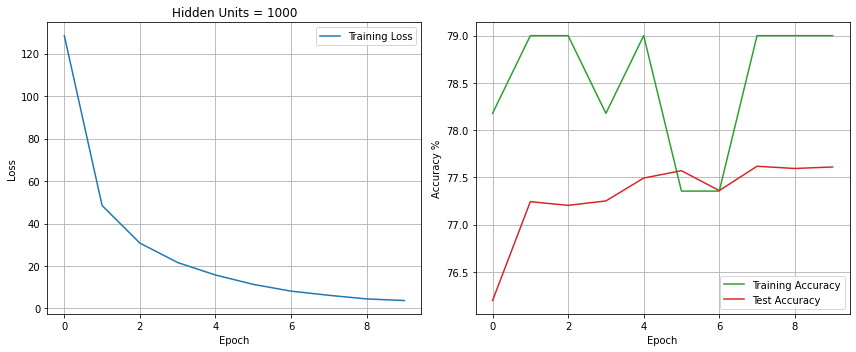

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].plot(range(epochs), train_loss, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend(loc='best', frameon=True)
ax[0].set_title(f'Hidden Units = {hidden_units}')

ax[1].plot(range(epochs), train_acc, label='Training Accuracy', color='tab:green')
ax[1].plot(range(epochs), test_acc, label='Test Accuracy', color='tab:red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].grid(True)
ax[1].legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig(f'images/mlp_ep_{epochs}_hdn_{hidden_units}.png')

In [20]:
epochs = 10
hidden_units = 10000
train_loss, train_acc, test_acc = baseline_mlp_train(trainloader, testloader, 
                                                     epochs, hidden_units)

100%|██████████| 10/10 [18:01<00:00, 108.13s/it]


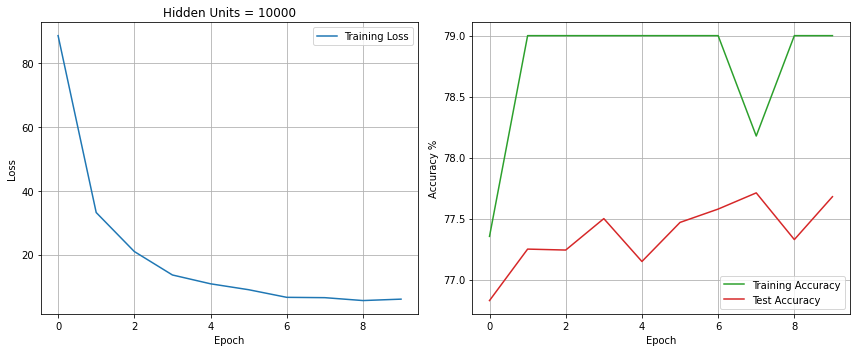

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].plot(range(epochs), train_loss, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend(loc='best', frameon=True)
ax[0].set_title(f'Hidden Units = {hidden_units}')

ax[1].plot(range(epochs), train_acc, label='Training Accuracy', color='tab:green')
ax[1].plot(range(epochs), test_acc, label='Test Accuracy', color='tab:red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].grid(True)
ax[1].legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig(f'images/mlp_ep_{epochs}_hdn_{hidden_units}.png')

In [22]:
epochs = 10
hidden_units = 100000
train_loss, train_acc, test_acc = baseline_mlp_train(trainloader, testloader, 
                                                     epochs, hidden_units)

100%|██████████| 10/10 [2:36:00<00:00, 936.08s/it] 


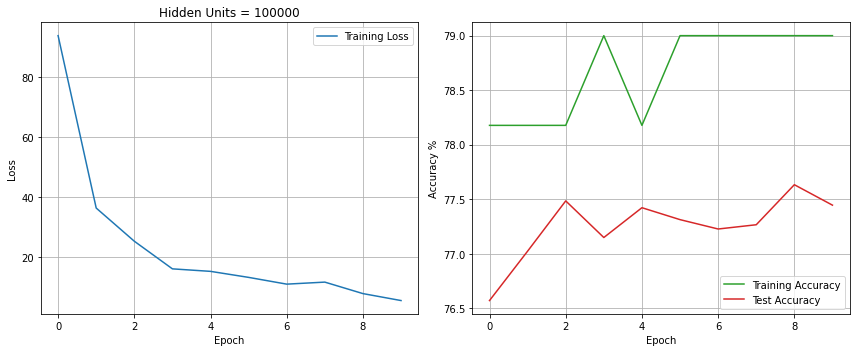

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].plot(range(epochs), train_loss, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend(loc='best', frameon=True)
ax[0].set_title(f'Hidden Units = {hidden_units}')

ax[1].plot(range(epochs), train_acc, label='Training Accuracy', color='tab:green')
ax[1].plot(range(epochs), test_acc, label='Test Accuracy', color='tab:red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].grid(True)
ax[1].legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig(f'images/mlp_ep_{epochs}_hdn_{hidden_units}.png')

### Misc

In [51]:
# this suppresses non-training functions such as gradient tracking.
model.eval()

correct = 0
total = 0
accuracies = []
with torch.no_grad():
    for (images, labels) in testloader:
        output = model(images)
        _, predicted = torch.max(output.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc = (correct * 100.0) / total
        accuracies.append(acc)
print(f'Test Accuracy: {accuracies[-1]}%')

SyntaxError: invalid syntax (<ipython-input-51-7704a70a8595>, line 7)

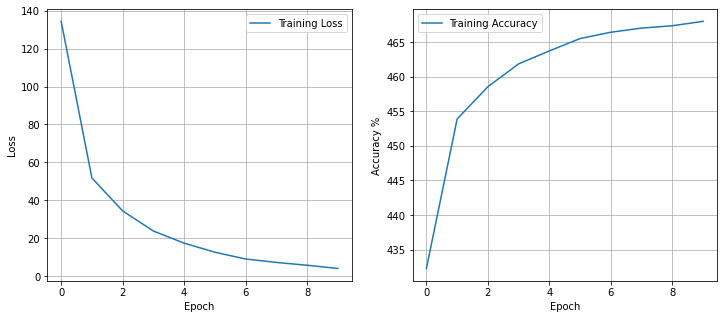

In [22]:
epochs = 10
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].plot(range(epochs), tr_loss, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend(loc='best', frameon=True)

ax[1].plot(range(epochs), tr_acc, label='Training Accuracy')
# ax[1].plot(range(epochs), acc_test, label='Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].grid(True)
ax[1].legend(loc='best', frameon=True)

In [9]:
# note 28x28 flattened image corresponds to vector of length 784
model = BaselineModel(input_size=784, hidden_size=784, num_classes=10)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

epochs = 10
training_losses = []

for epoch in tqdm(range(epochs)):
    ep_loss = 0.0
    for (images, labels) in trainloader:
        # zero gradients
        optimiser.zero_grad()
        # compute loss
        output = model(images)
        loss = loss_fn(output, labels)
        # backprop
        loss.backward()
        # step optimiser
        optimiser.step()
        # track epoch loss
        ep_loss += loss.item()
    training_losses.append(ep_loss)
print('Training complete.')

  0%|          | 0/10 [00:00<?, ?it/s]

Training complete.


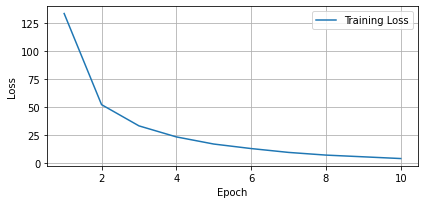

In [41]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(range(1,11), training_losses, label='Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='best', frameon=True)
ax.grid(True)
plt.tight_layout()

In [10]:
def eval_accuracy(predictions, labels):
    return ((torch.eq(predictions, labels).sum() / labels.shape[0]) * 100).item()

In [52]:
# set model into evaluation mode
# this suppresses non-training functions such as gradient tracking.
model.eval()

correct = 0
total = 0
accuracies = []
with torch.no_grad():
    for (images, labels) in testloader:
        output = model(images)
        _, predicted = torch.max(output.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc = (correct * 100.0) / total
        accuracies.append(acc)
print(f'Test Accuracy: {accuracies[-1]}%')

NameError: name 'model' is not defined

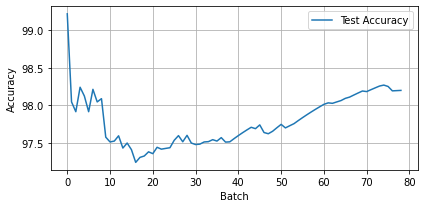

In [52]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(range(len(accuracies)), accuracies, label='Test Accuracy')
ax.set_xlabel('Batch')
ax.set_ylabel('Accuracy')
ax.legend(loc='best', frameon=True)
ax.grid(True)
plt.tight_layout()